In [ ]:
# default_exp core

# Analysis of Star Column

>Objective: 
The objective of this notebook is to analyse and understand "Star" of lesson feedback. To understand we would try to do the following steps:
>>- Load the pre-processed data
>>- See Word Clouds to know which are the most prominent words
>>- See Word Cloud of different part of speech: Noun, Verb, Adjective, Adverb
>>- See Bigram/Trigram for words/phrases
>>- See Network graph of Bigram/Trigram
>>- See how the rating varries with different Bigrams/Trigrams

In [ ]:
#hide
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
import yaml
from tqdm import tqdm
from pandas.core.common import flatten
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_columns', 500)
plt.rcParams['font.size'] = '12'

## Load Data

In [ ]:
#hide
# path = r'C:\Users\cha95906\OneDrive - Mott MacDonald\SSO Lesson observations'
path ='/mnt/c/Users/cha95906/OneDrive - Mott MacDonald/SSO Lesson observations'
df_sub = pd.read_csv(os.path.join(path,'cleaned4.csv'))
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words |= {"teacher","student","students","lesson","class","pupil","pupils"}
df_sub['date_start'] = pd.to_datetime(df_sub['date_start'])
df_sub['year'] = df_sub.date_start.apply(lambda x: str(x.year))
df_sub['month'] = df_sub.date_start.apply(lambda x: x.month)

In [ ]:
df_sub.head(2)

Unnamed: 0 date_start location.district_label  \
0           0 2019-10-16                      Bo   
1           1 2020-02-12      Western Area Urban   

                      location.school_label  cd_teacher_name cd_class  \
0  Kaku A Community Junior Secondary School      Moses Simbo     jss1   
1           Baptist Junior Secondary School  Mr David Kamara     jss1   

  cd_subject  cd_girlspresent  cd_boyspresent location.school_school_level  \
0       math             12.0            10.0             Junior Secondary   
1    english             25.0            23.0             Junior Secondary   

                                   co_star1  \
0  Teacher involved pupils in to the lesson   
1                                   Content   

                                    co_star1_example                co_star2  \
0  Teacher involved pupils in the lesson during t...  Teacher avoid flogging   
1  The teacher is comfortable and in control of t...              Assessment   

                                    co_star2_example  \
0     Teacher did not flog pupils during the lesson.   
1  The teacher uses different methods of assessin...   

                                             co_wish  \
0  teacher did not scanned the class during the o...   
1  to be more audible in the next lesson. feedbac...   

                                     co_wish_actions  \
0  SSO engaged and encourage the teacher to pleas...   
1    Feedback session with teacher after observation   

                                      feedback_notes  co_lpm_follow  \
0  teacher did not scanned the class during the o...            2.0   
1                                                NaN            4.0   

   Pedagogy composite score (max of 24)  \
0                                    13   
1                                     5   

                                             co_star  \
0  teacher involved pupils in to the lesson. teac...   
1  content. the teacher is comfortable and in con...   

                                       co_star_clean  \
0  teacher involved pupils lesson teacher involve...   
1  content teacher comfortable control content ta...   

                                       co_wish_clean  \
0  teacher scanned class opening lesson sso engag...   
1  audible lesson feedback session teacher observ...   

                   feedback_notes_clean  \
0  teacher scanned class opening lesson   
1                                   NaN   

                                 co_star_clean_lemma  \
0  teacher involve pupil lesson teacher involve p...   
1  content teacher comfortable control content te...   

                                 co_wish_clean_lemma  \
0  teacher scan class opening lesson sso engage e...   
1  audible lesson feedback session teacher observ...   

          feedback_notes_clean_lemma  \
0  teacher scan class opening lesson   
1                                NaN   

                                   co_star_pos_lemma  \
0  {'NOUN': ['teacher', 'pupil', 'lesson', 'pract...   
1  {'NOUN': ['content', 'teacher', 'control', 'as...   

                                   co_wish_pos_lemma  \
0  {'NOUN': ['teacher', 'class', 'opening', 'less...   
1  {'PART': 'to', 'VERB': 'be', 'ADV': 'more', 'A...   

                            feedback_notes_pos_lemma  year  month  
0  {'NOUN': ['teacher', 'class', 'opening', 'less...  2019   10.0  
1                                    {'NOUN': 'nan'}  2020    2.0

## Visualize Word Cloud of Star
> Visialise word cloud of top 50 words of cleaned star field, this would probably give us a overall understanding of what are the most common words being used over the years for filling up Star column of lesson feedback. 

> In this we have skipped following words after initial trial as they are known to be present in the dataset and will not add much insight for us. Skipped words are: {"teacher","student","students","lesson","class","pupil","pupils"}

In [ ]:
#export
def return_wc(x,max_word=50,facecolor='k',bg_color='white'):
    wordcloud = WordCloud(background_color=bg_color,width=1600,
                          stopwords=nlp.Defaults.stop_words,max_words=max_word,
                          height=800).generate(x)
    return wordcloud  

def plot_wc(x,max_word=50,facecolor='k',title='None',bg_color='white'):
    wordcloud = return_wc(x,max_word,facecolor,bg_color)
    plt.figure( figsize=(20,10),facecolor=facecolor)
    if title !='None': 
        plt.title(title,fontsize=50)
        plt.axis('off')
    plt.imshow(wordcloud)    

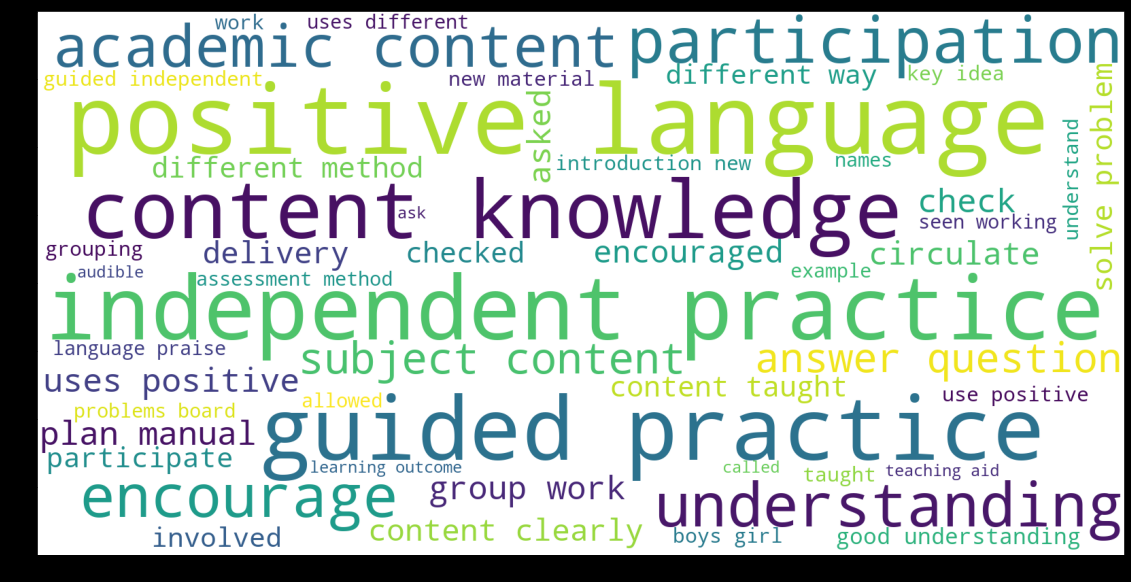

In [ ]:
co_star_clean = ' '.join(df_sub['co_star_clean'].tolist())
plot_wc(co_star_clean)

## Visualize Word Cloud of different Part of Speech
> Since we have done part of speech tagging it would be interesting to see word cloud for different part of speech, we would try to see word cloud of Verbs, Nouns, Adjectives, Adverbs seprately, which woudl probably add more insight.

In [ ]:
#hide
df_sub['co_star_pos_lemma'] = df_sub['co_star_pos_lemma'].apply(lambda x: x.replace('/',''))

In [ ]:
#hide
tqdm.pandas()
df_sub['co_star_pos_lemma_dict'] = df_sub['co_star_pos_lemma'].progress_apply(lambda x: yaml.load(x))

100%|██████████| 69200/69200 [01:47<00:00, 646.02it/s]


In [ ]:
#export
def set_key(dictionary, key, value):
    if key not in dictionary:
        dictionary[key] = value
    elif type(dictionary[key]) == list:
        dictionary[key].append(value)
    else:
        dictionary[key] = [dictionary[key], value]
        
def separate_pos(df):
#     df['co_star_pos_lemma_dict'] = df['co_star_pos_lemma'].progress_apply(lambda x: yaml.load(x))
    df = df.reset_index()
    lemma_dict = df['co_star_pos_lemma_dict'].to_dict()
    lemma_dict_c = lemma_dict.copy()
    
    comp_dict = {}
#     print(len(lemma_dict_c))
    for lm in range(len(lemma_dict_c)):
        dict1 = lemma_dict_c[lm]
        keys = dict1.keys()
        for key in keys:
            set_key(comp_dict,key,dict1[key])
    
    verbs = ' '.join(list(flatten(comp_dict['VERB'])))
    noun = ' '.join(list(flatten(comp_dict['NOUN'])))
    adj = ' '.join(list(flatten(comp_dict['ADJ'])))
    adv = ' '.join(list(flatten(comp_dict['ADV'])))
    
    return verbs,noun,adj,adv

In [ ]:
#hide
verbs,noun,adj,adv = separate_pos(df_sub)

### Top 50 Verbs of Star Field

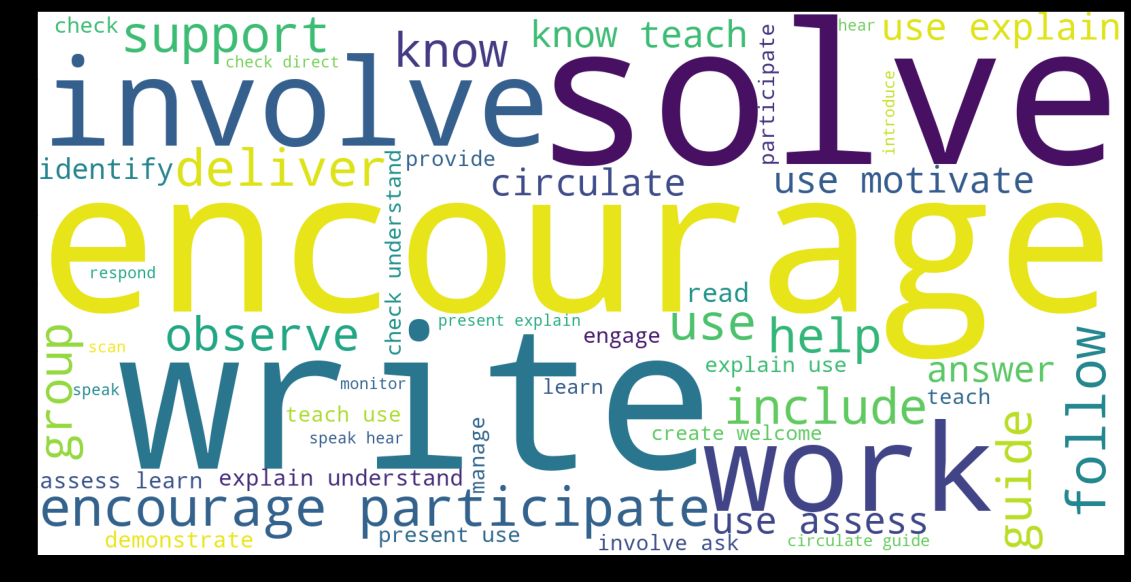

In [ ]:
plot_wc(verbs)

### Top 50 NOUN of Star field

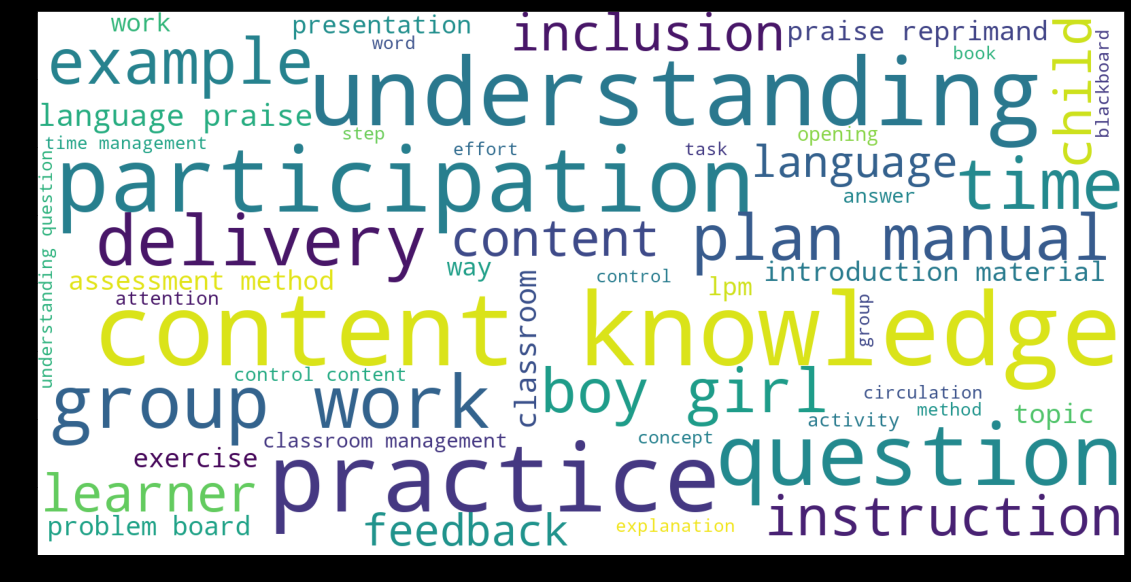

In [ ]:
plot_wc(noun)

###  Top 20 ADJECTIVE of Star field

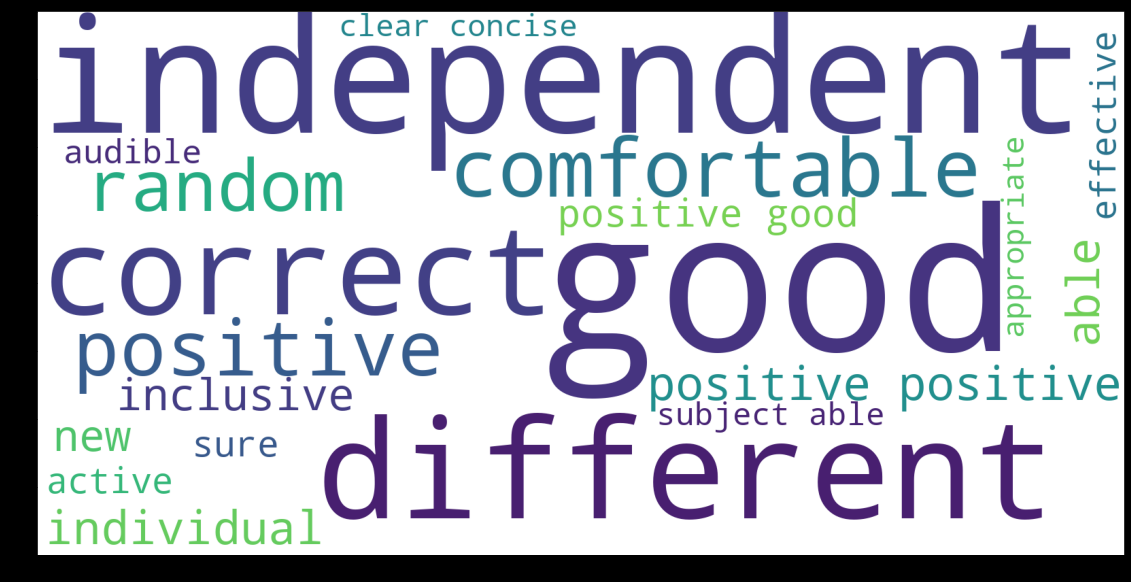

In [ ]:
plot_wc(adj,20)

### Top 20 ADVERB of Star field

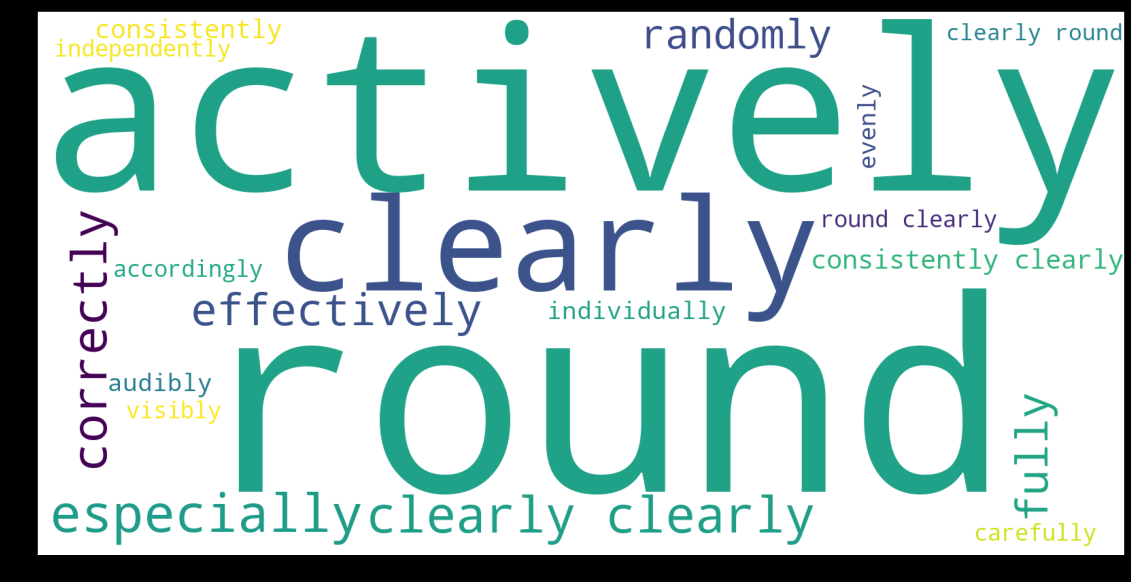

In [ ]:
plot_wc(adv,20)

## Bigram and Trigram of words
> Word cloud is good for understanding single word emphasis, but if we want to understand phrase in sentence Bigram/Trigram method is good. So we will be able to understand which are the most common phrases used in star column.

In [ ]:
#export
nlp = spacy.load("en_core_web_sm")
stoplist = nlp.Defaults.stop_words

def calculate_ngram(df,col='co_star_clean'):
    c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
    ngrams = c_vec.fit_transform(df[col])
    ngrams = ngrams.astype(np.int8)
    count_values = ngrams.toarray().sum(axis=0)
    
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
                ).rename(columns={0: 'frequency', 1:'bigram'})
    return df_ngram[:50]
    

In [ ]:
#hide
df = calculate_ngram(df_sub)    

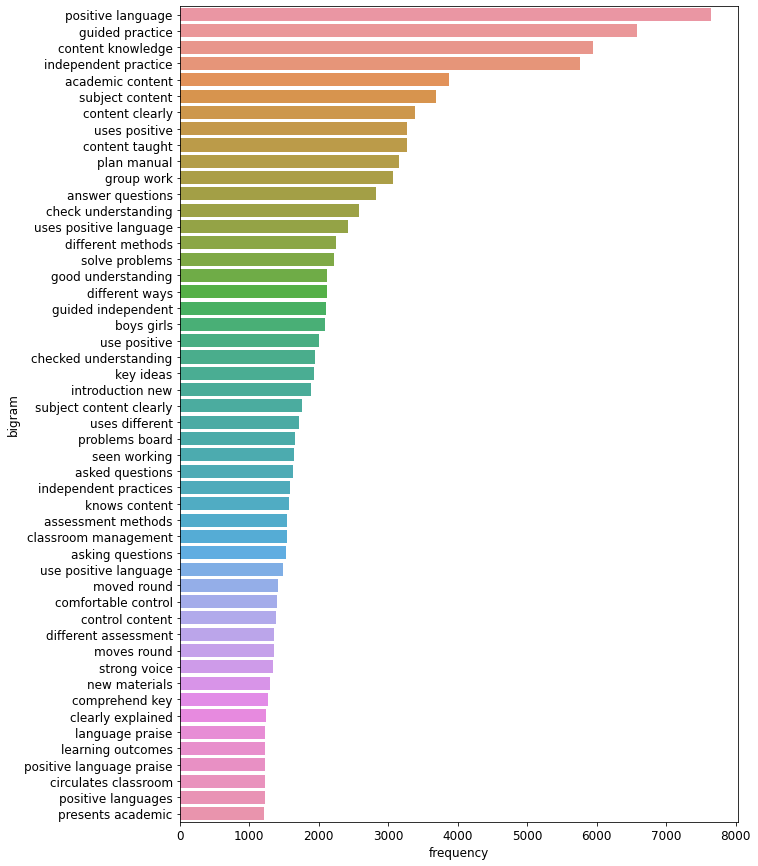

In [ ]:
plt.figure(figsize=(10,15))
sns.barplot(df.frequency,df['bigram'])
plt.show()

## Word Net Visualisation
> Many words are common accross Bigram, so let us see network graph of them

In [ ]:
#hide
df['bigram_tuple'] = df.bigram.apply(lambda x: (x.split(' ')[0],x.split(' ')[1]))

In [ ]:
#export
def visulaizeBigrams(bigram_df, K):
    d = bigram_df.set_index('bigram_tuple').T.to_dict('records')
#     print(d)
    # Create network plot 
    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
#         print(k[0],v)
        G.add_edge(k[0], k[1], weight=(v * 10))

    #G.add_node("china", weight=100)
    fig, ax = plt.subplots(figsize=(20, 16))
    
    # k : float (default=None)
    # Optimal distance between nodes. 
    # If None the distance is set to 1/sqrt(n) where n is the number of nodes. Increase this value to move nodes farther apart.
    pos = nx.spring_layout(G, k=K)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=13,
                     width=2,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.02, value[1]+.045
#         print(key)
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=13)
    plt.grid(True)
    plt.show()

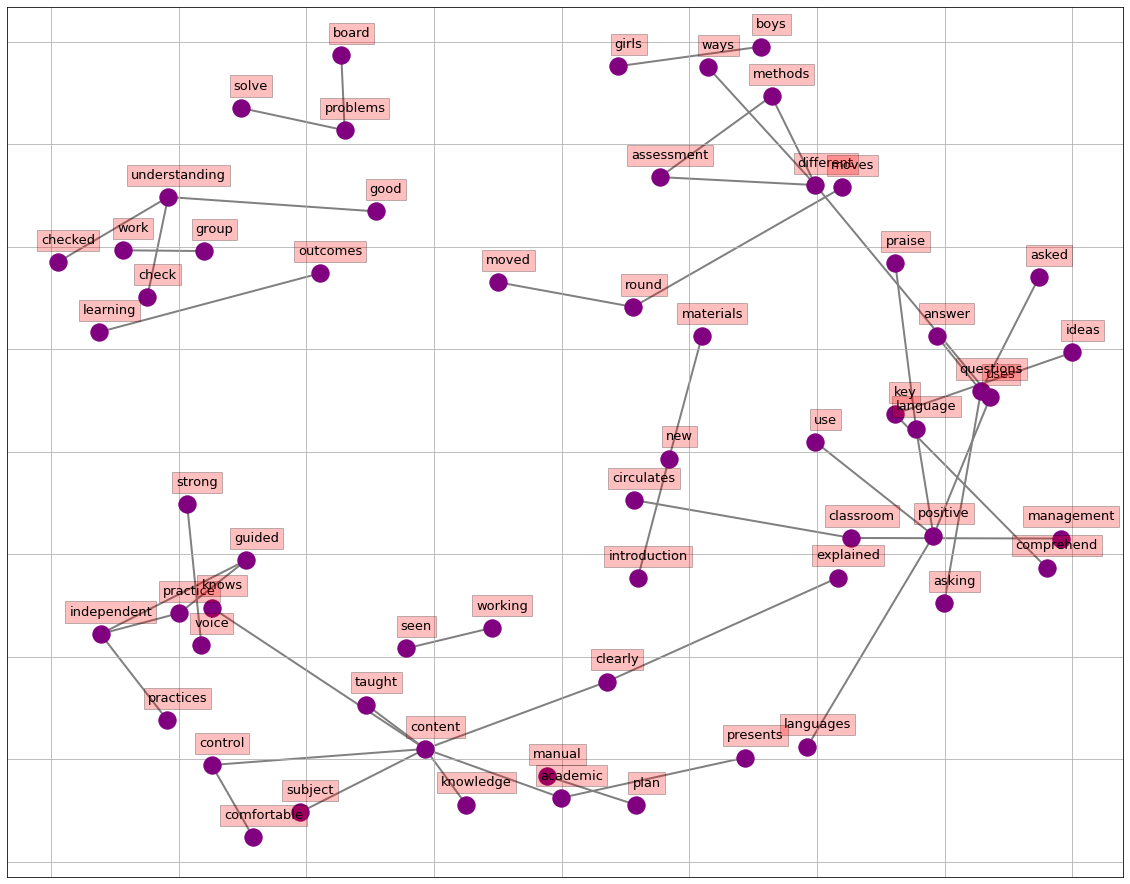

In [ ]:
visulaizeBigrams(bigram_df=df, K=12)

## Varriation of rating with Bigrams/Trigrams
>Let us now see how the ratings (co_lpm_follow) varry with star bigram

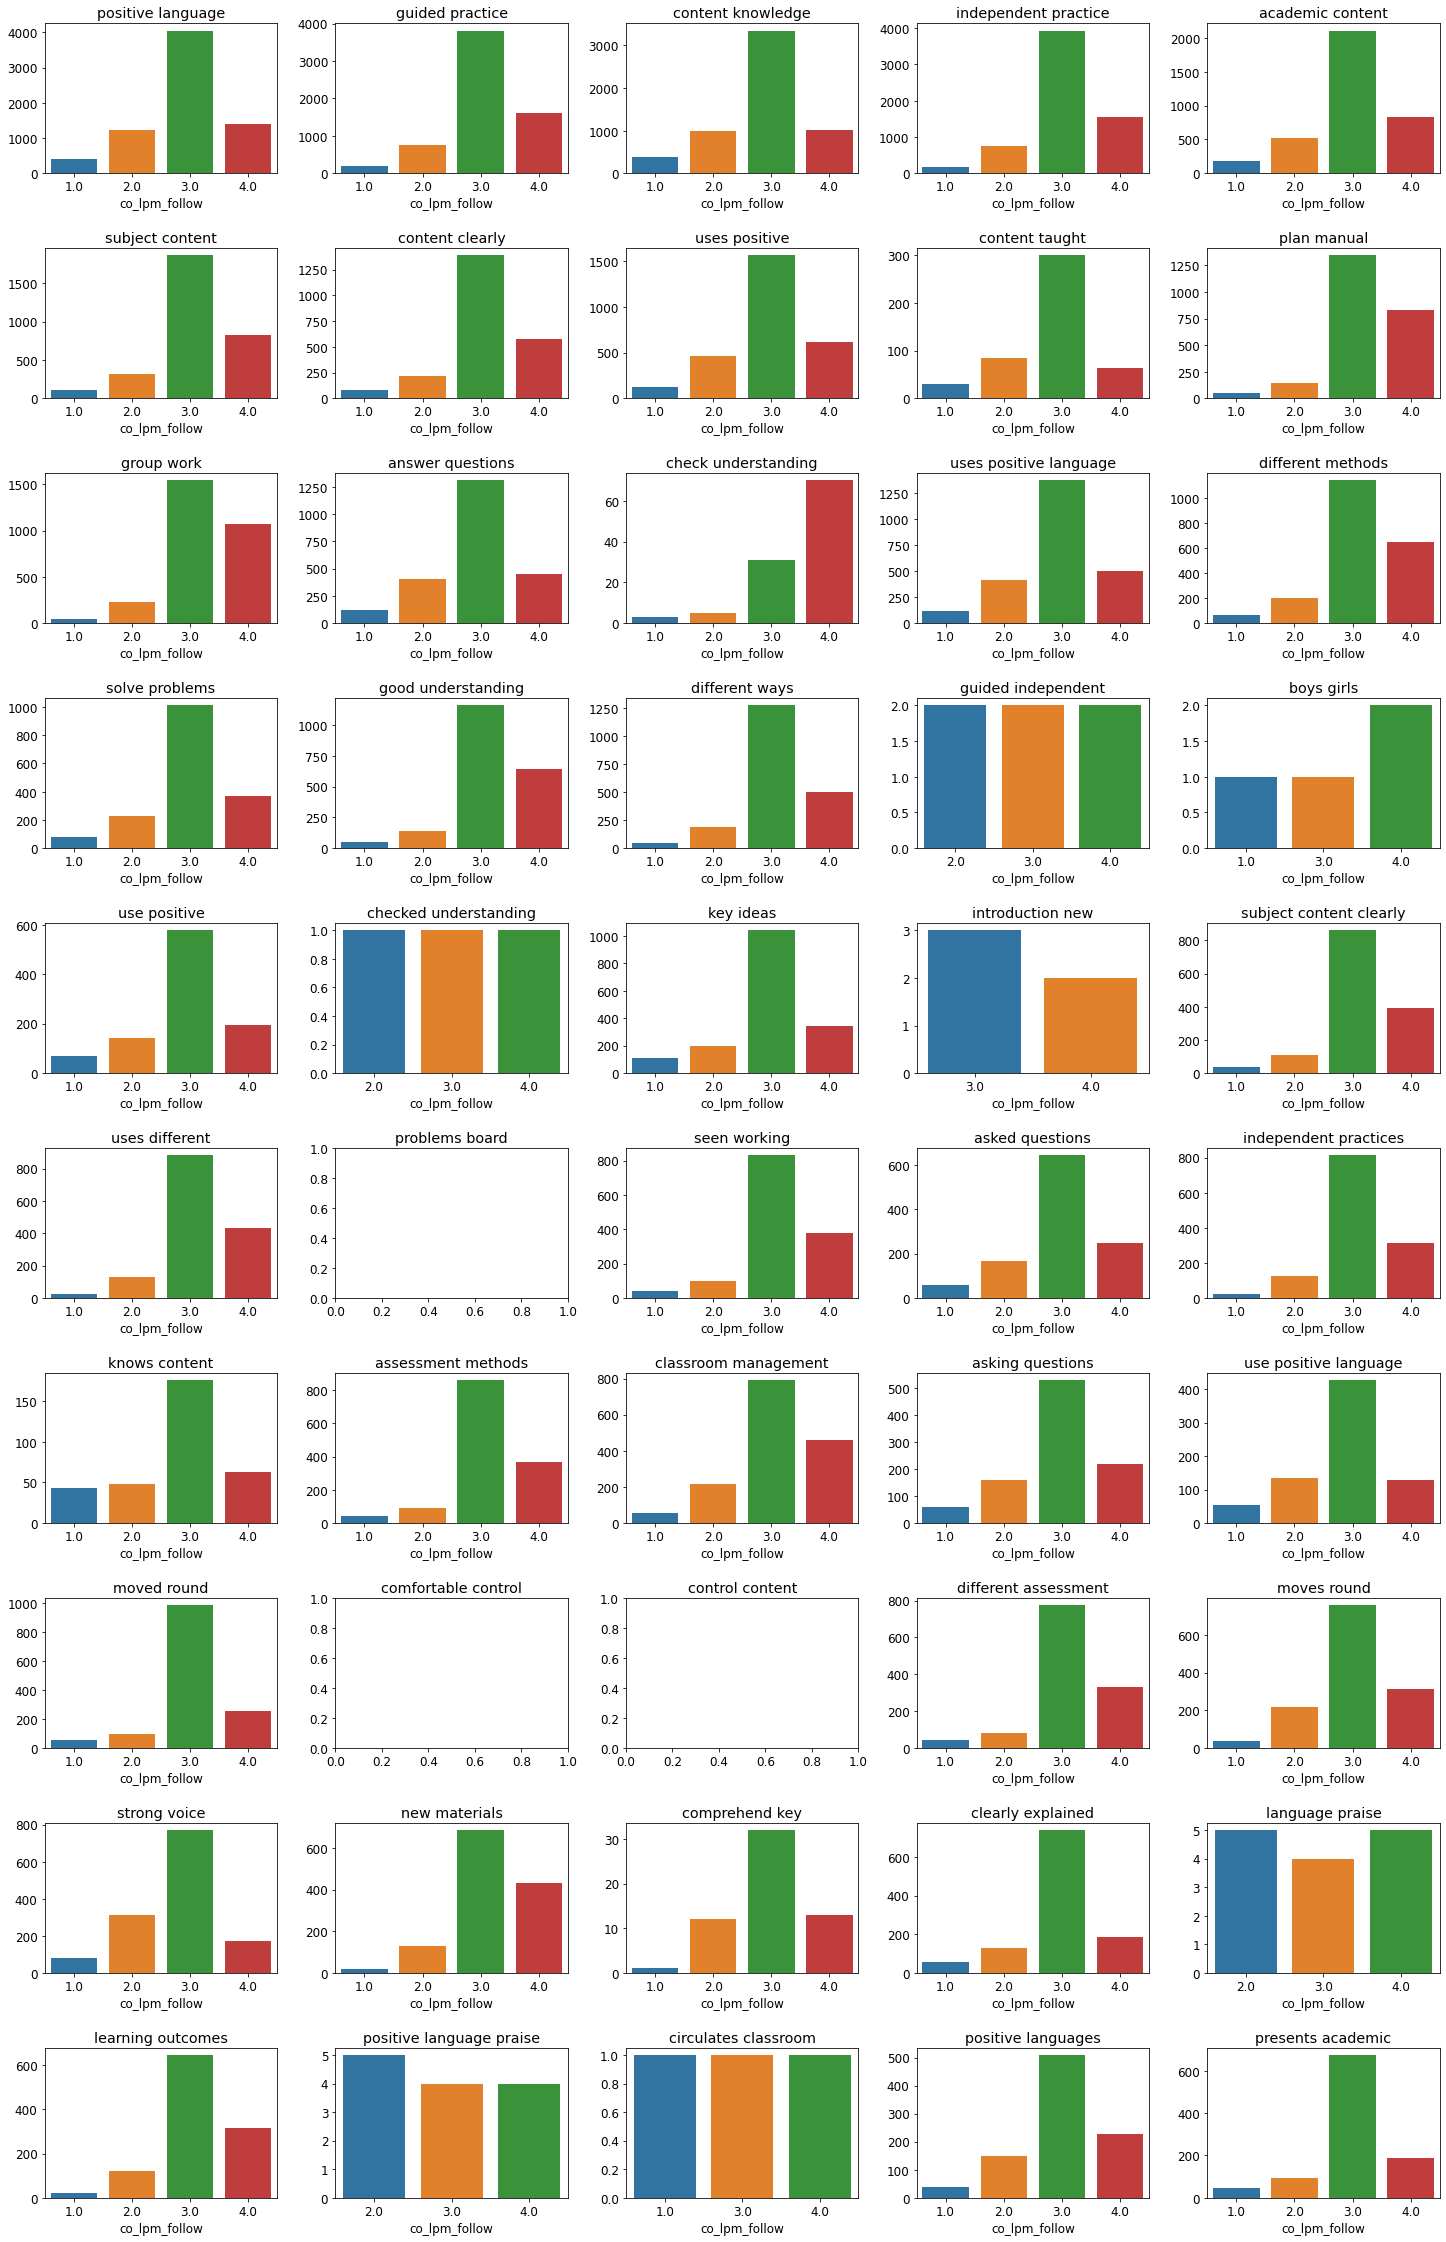

In [ ]:
fig, axs = plt.subplots(10,5, figsize=(25, 40), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.25)
axs = axs.ravel()

for i in range(len(df)):
    bigram = df.bigram[i]
    test_df = df_sub[df_sub['co_star'].str.contains(bigram)]    
    ser = test_df.groupby('co_lpm_follow').count()['cd_class']
    try:
        sns.barplot(x=ser.index,y=ser.values,ax = axs[i])
    except:
        pass
    axs[i].set_title(bigram)


## Varriation of STAR between years
> How the star varry over the years - 2018 to 2020?

### What are the top most words of STAR for yearly data

In [ ]:
#export
def plot_multi_wc(n_topic,word_clouds,texts):
    nrows=n_topic//2
    fig, axs = plt.subplots(nrows,2, figsize=(16, 8*n_topic//4), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()
    
    for i,[text, wc] in enumerate(zip(texts,word_clouds)):
        axs[i].imshow(wc)
        axs[i].axis('off')
        axs[i].set_title(text,fontsize=20) 

In [ ]:
#hide
years = ['2018','2019','2020',"2021"]
wcs = []
texts = ["Top 50 STAR words of {}".format(i) for i in years]

for i,year in enumerate(years):
    df_sub_year = df_sub[df_sub['year']==year]
    co_star_clean = ' '.join(df_sub_year['co_star_clean'].tolist())
    wc = return_wc(co_star_clean,facecolor='white',bg_color='black')
    wcs.append(wc)    
 

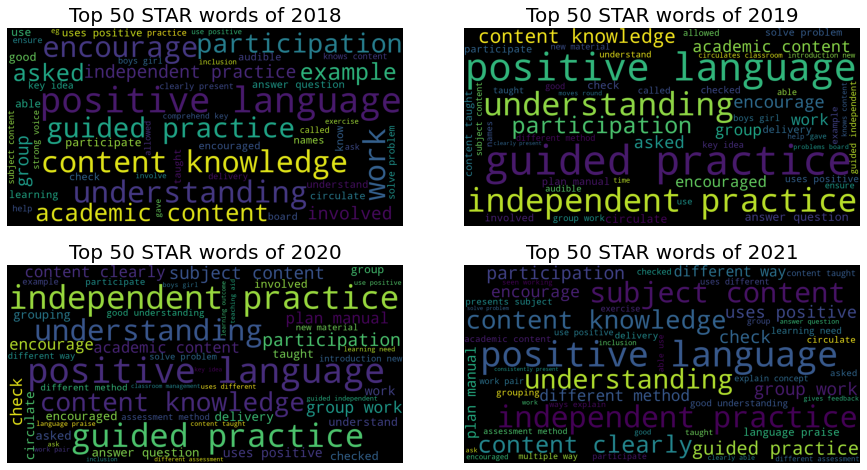

In [ ]:
   
plot_multi_wc(len(years),wcs,texts)

### What the top POS: Verbs, Nouns, Adverbs, Adjectives in yearly data

In [ ]:
#hide
verbs,nouns,adjs,advs = [],[],[],[]

for year in years:
    df_sub_year = df_sub[df_sub['year']==year]
    poss = separate_pos(df_sub_year)

    wc_vb = return_wc(poss[0],20,facecolor='white',bg_color='black')
    wc_n = return_wc(poss[1],20,facecolor='white',bg_color='black')
    wc_adj = return_wc(poss[2],20,facecolor='white',bg_color='black')
    wc_adv = return_wc(poss[3],20,facecolor='white',bg_color='black')

    verbs.append(wc_vb)
    nouns.append(wc_n)
    adjs.append(wc_adj)
    advs.append(wc_adv)  

#### Top 20 Verbs between years

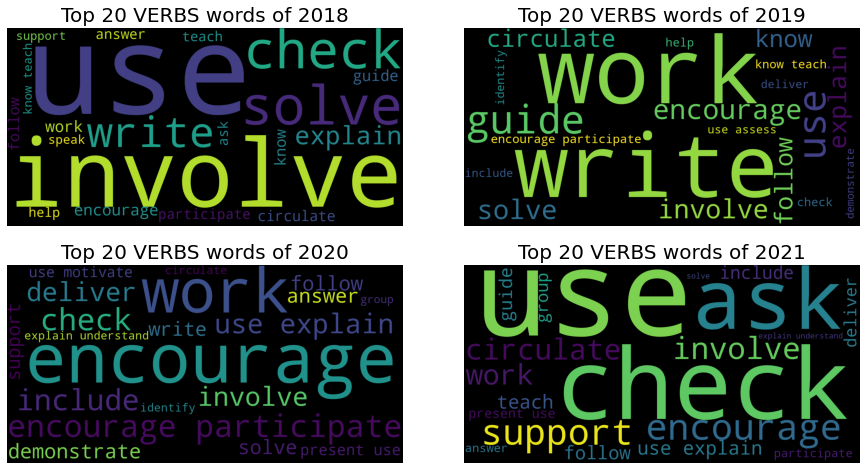

In [ ]:
texts = ["Top 20 VERBS words of {}".format(i) for i in years]
plot_multi_wc(len(years),verbs,texts)

#### Top 20 Nouns between years

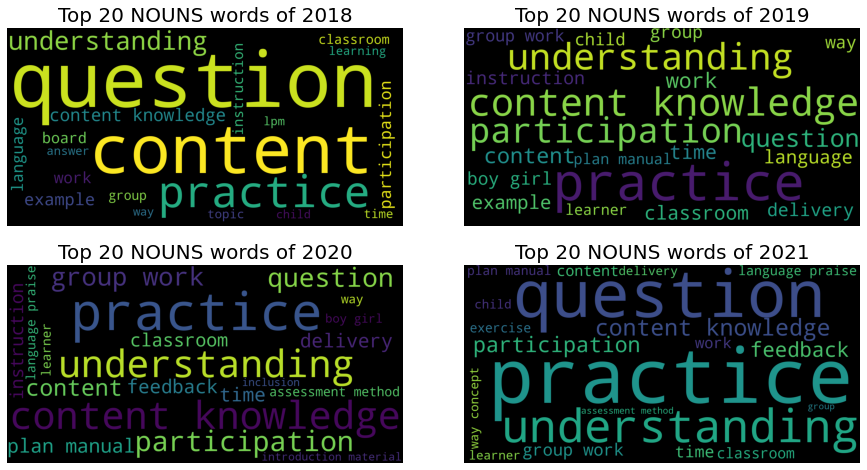

In [ ]:
texts = ["Top 20 NOUNS words of {}".format(i) for i in years]
plot_multi_wc(len(years),nouns,texts)

#### Top 20 Adjectives between years

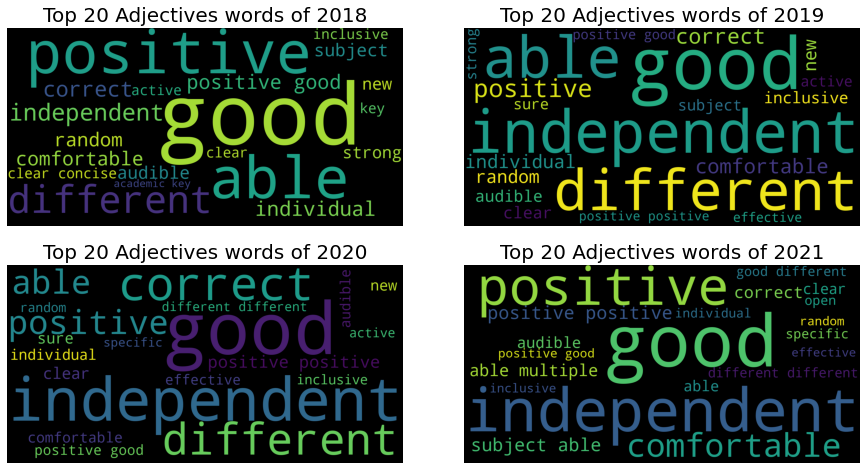

In [ ]:
texts = ["Top 20 Adjectives words of {}".format(i) for i in years]
plot_multi_wc(len(years),adjs,texts)

#### Top 20 Adverbs between years

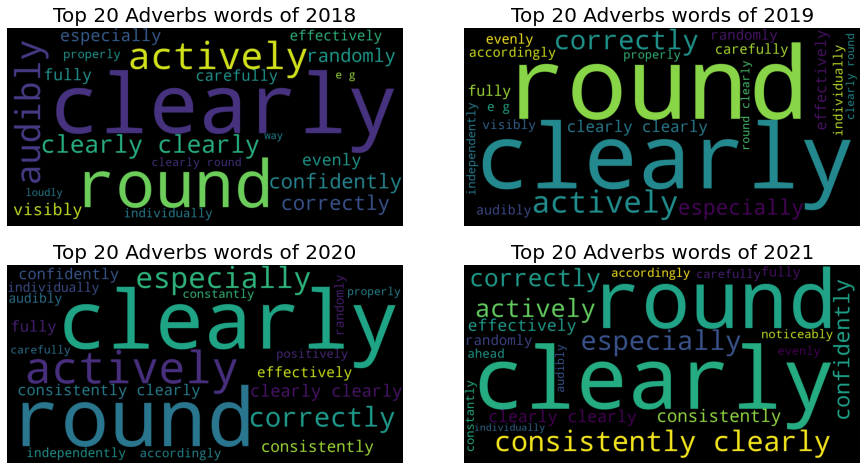

In [ ]:
texts = ["Top 20 Adverbs words of {}".format(i) for i in years]
plot_multi_wc(len(years),advs,texts)

## Variation of Bigram/Trigram between the years
> How does Bigram/Trigram varry over the years??

In [ ]:
#hide
bigrams = []
for year in years:
    df_sub_year = df_sub[df_sub['year']==year]
    df_bigram = calculate_ngram(df_sub_year)
    df_bigram['bigram_tuple'] = df_bigram.bigram.apply(lambda x: (x.split(' ')[0],x.split(' ')[1]))
    bigrams.append(df_bigram)

In [ ]:
#export
def plot_bigram(bigrams,texts):
    nrows = len(bigrams)//2
    fig, axs = plt.subplots(nrows,2, figsize=(20,15*nrows))
    fig.subplots_adjust(hspace = .2, wspace=.5)
    axs = axs.ravel()
    
    for i,[text,df] in enumerate(zip(texts,bigrams)):
        sns.barplot(df.frequency,df['bigram'],ax=axs[i],palette='tab20b')
        axs[i].set_title(text,fontsize=20)     

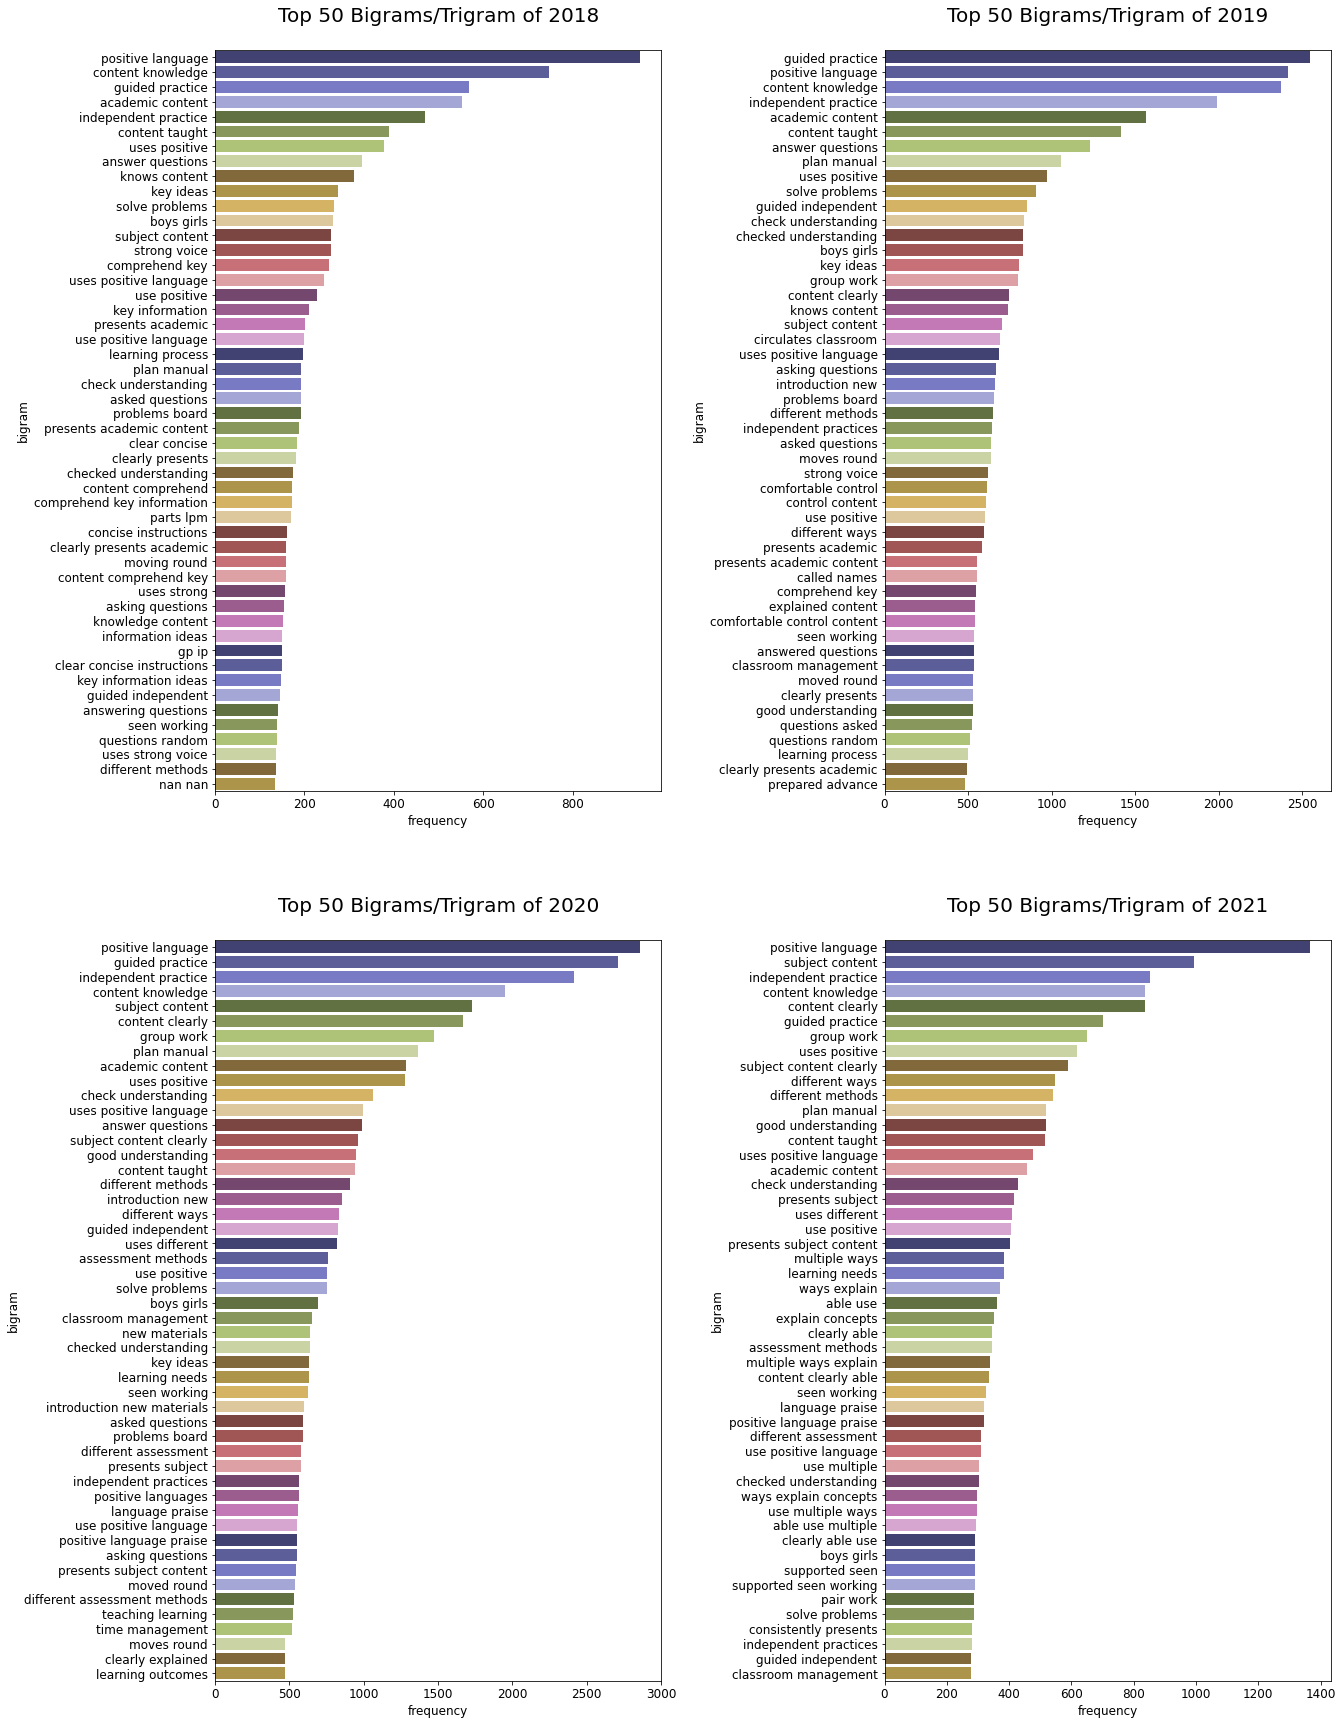

In [ ]:
texts = ["Top 50 Bigrams/Trigram of {}\n".format(i) for i in years]
plot_bigram(bigrams,texts)

#### Word Net of Bigram/Trigram between years

In [ ]:
#export
def visulaizeBigrams_multi(bigram_dfs, texts,K):
    fig, axs = plt.subplots(2,2, figsize=(30,12*2))
    fig.subplots_adjust(hspace = 0.1, wspace=.05)
    axs = axs.ravel()
    
    for i, [bigram_df,text] in enumerate(zip(bigram_dfs,texts)):
        d = bigram_df.set_index('bigram_tuple').T.to_dict('records')
    #     print(d)
        # Create network plot 
        G = nx.Graph()

        # Create connections between nodes
        for k, v in d[0].items():
    #         print(k[0],v)
            G.add_edge(k[0], k[1], weight=(v * 10))
        pos = nx.spring_layout(G, k=K)

        # Plot networks
        nx.draw_networkx(G, pos,
                         font_size=13,
                         width=2,
                         edge_color='grey',
                         node_color='purple',
                         with_labels = False,
                         ax=axs[i])

        # Create offset labels
        for key, value in pos.items():
            x, y = value[0]+.02, value[1]+.045
    #         print(key)
            axs[i].text(x, y,
                    s=key,
                    bbox=dict(facecolor='red', alpha=0.25),
                    horizontalalignment='center', fontsize=15)
            axs[i].grid(True)
            axs[i].set_title(text,fontsize=30)   


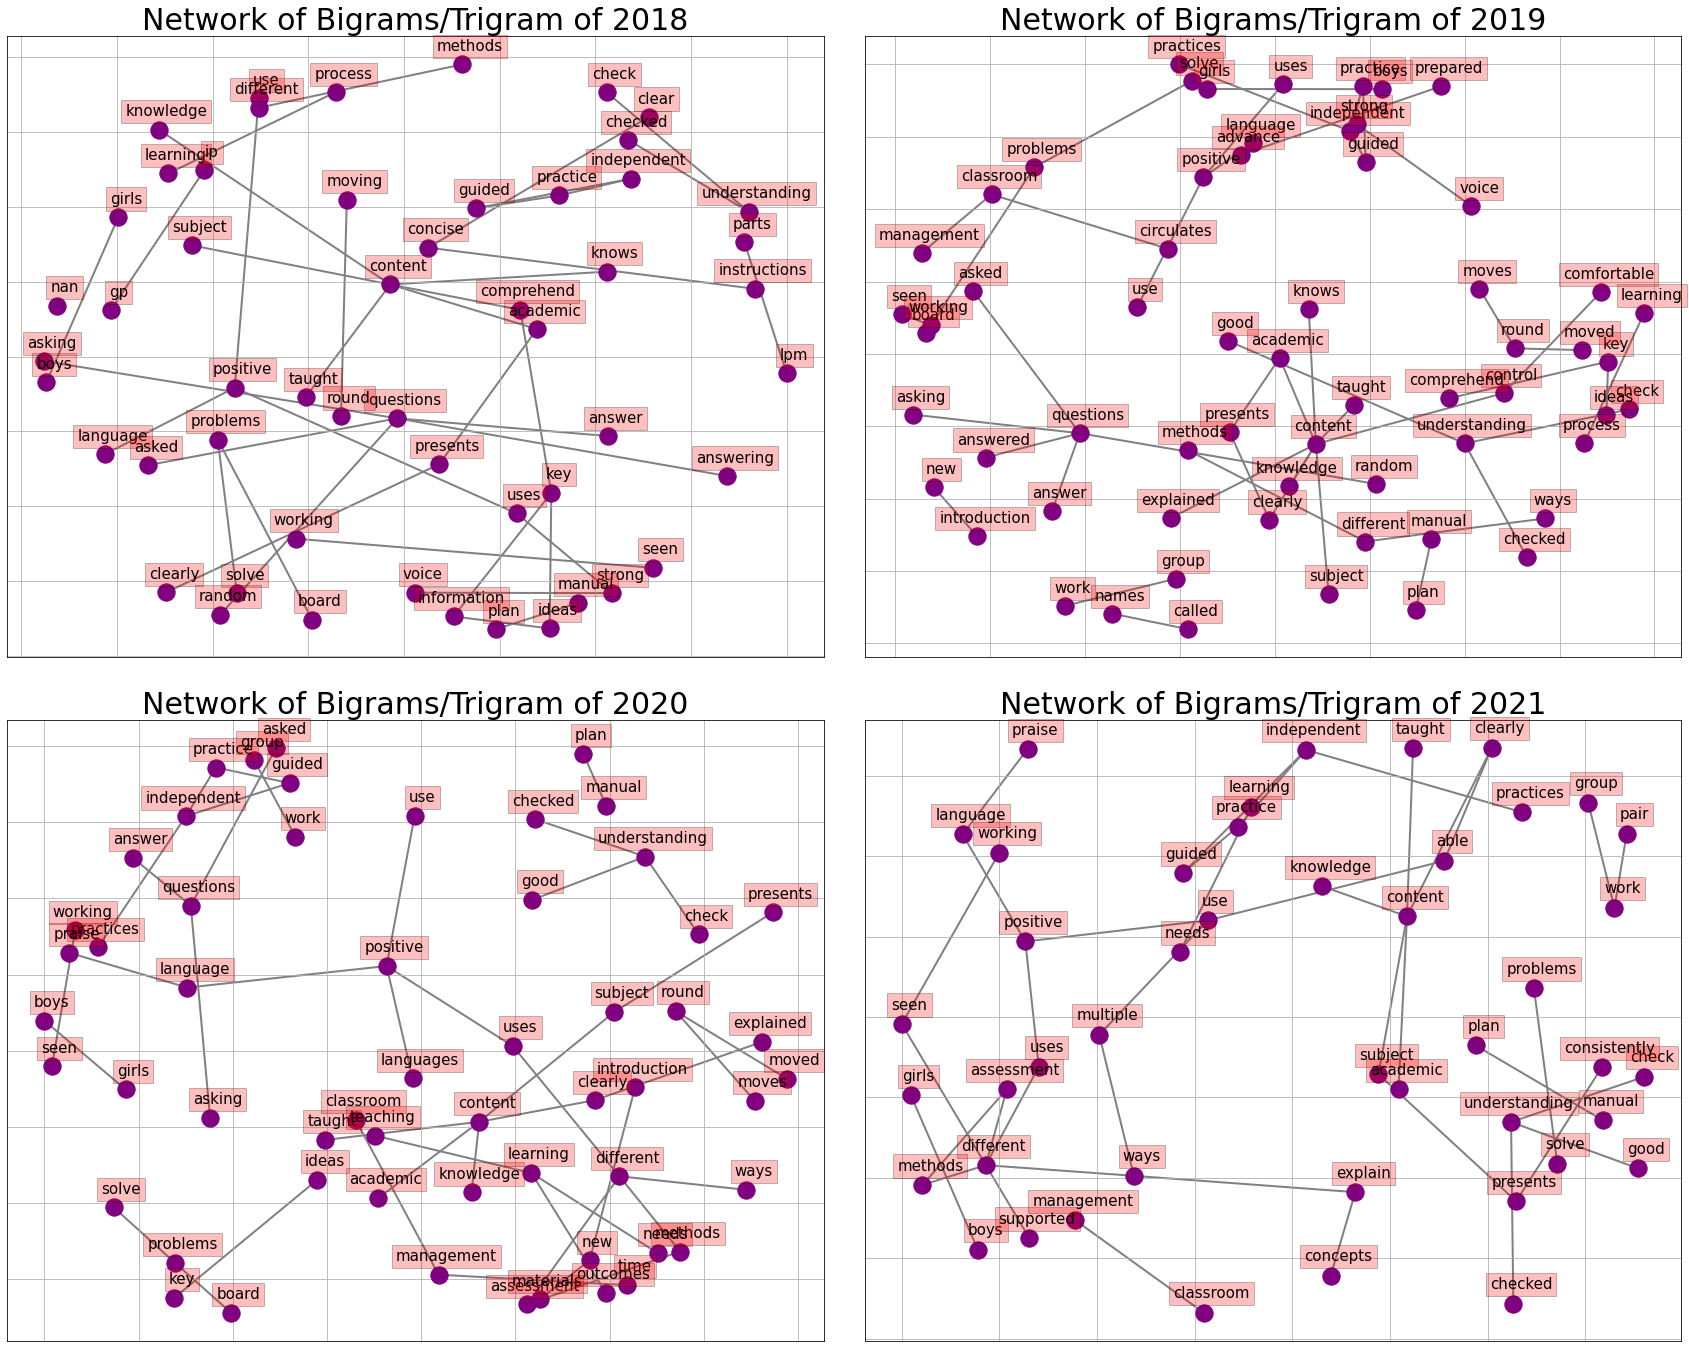

In [ ]:
texts = ["Network of Bigrams/Trigram of {}".format(i) for i in years]
visulaizeBigrams_multi(bigrams,texts,K=10)